In [1]:
from torch.utils.data import Dataset, DataLoader
from torch.nn import Linear, CrossEntropyLoss
from torchvision import transforms, models
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import torchvision
import pathlib
import pickle
import torch
import os
import gc

In [2]:
class ResnetWrapper(nn.Module):
    def __init__(self):
        super(ResnetWrapper, self).__init__()
        self.resnet = models.resnet152(pretrained=True)
        self.fc = Linear(2048, 2, bias=True)
        self.set_for_finetune()

    def set_for_finetune(self):
        nn.init.xavier_normal_(self.fc.weight)

        for l in self.resnet.conv1.parameters():
            l.requires_grad = False
        for l in self.resnet.bn1.parameters():
            l.requires_grad = False
        for layer in [self.resnet.layer1, self.resnet.layer2, self.resnet.layer3, self.resnet.layer4]:
            for l in layer.parameters():
                l.requires_grad = False
        self.resnet.fc = self.fc

    def forward(self, x):
        return self.resnet(x)


In [3]:
# Data path: /kaggle/input/byu-tomography/
class BevDataset(Dataset):
  def __init__(self, root='.', size=224, split='train'):
    self.split = split
    postfix = split
    root = os.path.join(root, 'data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, postfix) ,transform = transforms.Compose([transforms.Resize((size,size)),transforms.ToTensor()]))

  def __getitem__(self,index):
    img = self.dataset_folder[index]
    path = self.dataset_folder.imgs[index]
    return img[0], img[1], path[0]

  def __len__(self):
    return len(self.dataset_folder)

In [4]:
# !mkdir data/train
# !unzip data/train.zip -d data/train

In [5]:
# !mkdir data/test
# !unzip data/validation.zip -d data/test

In [6]:
# # Reformat the data into negative and positive values
# from pathlib import Path
# import pathlib
# train_path = 'data/train'
# test_path = 'data/test'
# val_path = 'data/val'


# if not Path(val_path).exists():
#     Path(val_path).mkdir()

# Path(f'{train_path}/positive').mkdir()
# Path(f'{train_path}/negative').mkdir()

# Path(f'{test_path}/positive').mkdir()
# Path(f'{test_path}/negative').mkdir()

# Path(f'{val_path}/positive').mkdir()
# Path(f'{val_path}/negative').mkdir()

In [4]:
import pandas as pd
df = pd.read_csv('data/train_labels.csv')

In [8]:
# # Separate the neg and pos for train set
# f_path, vis = df['external_id'], df['motor_visible']

# for f_name, v in  zip(f_path,vis):
#     Path(f'{train_path}/{f_name}').rename(f'{train_path}/negative/{f_name}') if v == 0 \
#         else Path(f'{train_path}/{f_name}').rename(f'{train_path}/positive/{f_name}')

In [9]:
# # Separate the pos and neg for test set
# for file in Path(test_path).iterdir():
#     if Path(file).is_dir(): continue

#     Path(f'{test_path}/{file.name}').rename(f'{test_path}/negative/{file.name}') if 'neg' in file.name \
#         else Path(f'{test_path}/{file.name}').rename(f'{test_path}/positive/{file.name}')

In [10]:
# # Create the validation set 
# for file in Path(train_path).iterdir():
#     files = [file for file in Path(file).iterdir()]
#     val_files = files[:len(files)//4]

#     [pathlib.Path(f).rename(f'{val_path}/{file.name}/{f.name}') for f in val_files]

In [11]:
from PIL import Image

def add_rotated_images(paths):
    for path in paths: 
        for file in Path(path).iterdir():
            if not Path(file).is_dir(): continue

            for img_path in Path(file).iterdir():
                img = Image.open(img_path.as_posix())
                img_90 = img.rotate(90)
                img_180 = img.rotate(180)
                img_270 = img.rotate(270)
                img_90.save(f'{path}/{file.name}/{img_path.name.removesuffix(".png")}_90.png')
                img_180.save(f'{path}/{file.name}/{img_path.name.removesuffix(".png")}_180.png')
                img_270.save(f'{path}/{file.name}/{img_path.name.removesuffix(".png")}_270.png')


# add_rotated_images([train_path, val_path])

In [5]:
batch_size = 100
lr = 2e-3
num_epochs = 10
model_path = 'model/best-mps-model-rotated-data.pkl'

In [6]:
device = torch.device('mps')

if pathlib.Path(model_path).exists():
    print('Model found!')
    print('Loading model...')
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
else:
    print('No model found')
    print('Creating model...')
    model = ResnetWrapper().to(device)

print('Model ready')

Model found!
Loading model...
Model ready


In [14]:
train_loader = DataLoader(BevDataset(), shuffle=True, batch_size=batch_size)
val_loader = DataLoader(BevDataset(split='val'), shuffle=True, batch_size=batch_size)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [15]:
train_losses = [.37]
train_accuracy = [.85]
val_losses = [.38]
val_accuracy = [.83]
best_accuracy = val_accuracy[-1]
best_loss = val_losses[-1]

model.train()
try:
    loop = tqdm(total=len(train_loader)*num_epochs, position=0)
    for epoch in range(num_epochs):
        train_epoch_losses = []
        train_epoch_accuracy = []
        for batch, (x, y_truth, img_names) in enumerate(train_loader):
            x, y_truth = x.to(device), y_truth.to(device)
            y_hat = model(x)

            optimizer.zero_grad()

            loss = criterion(y_hat, y_truth)
            train_epoch_losses.append(loss.item())

            accuracy = (y_hat.argmax(1) == y_truth).float().mean()
            train_epoch_accuracy.append(accuracy.item())
            
            loss.backward()
            optimizer.step()

            # img_names = [path[i].split('/')[4] for i in range(len(path))]
            loop.set_description(f'epoch: {epoch} batch: {batch} train loss: {train_losses[-1]:.4f} val loss: {val_losses[-1]:.4f} train accuracy: {train_accuracy[-1]:.2f} val accuracy: {val_accuracy[-1]:.2f}')
            loop.update(1)
        
        train_losses.append(sum(train_epoch_losses) / len(train_epoch_losses)) 
        train_accuracy.append(sum(train_epoch_accuracy) / len(train_epoch_accuracy))
        
        print()
        val_epoch_loss = []
        val_epoch_accuracy = []
        val_loop = tqdm(total=len(val_loader), position=0)
        for x, y_truth, _ in val_loader:
            x, y_truth = x.to(device), y_truth.to(device)
            y_hat = model(x)

            optimizer.zero_grad()

            loss = criterion(y_hat, y_truth)
            val_epoch_loss.append(loss.item())

            accuracy = (y_hat.argmax(1) == y_truth).float().mean()
            val_epoch_accuracy.append(accuracy.item())

            loss.backward()
            optimizer.step()
            val_loop.update(1)
        val_loop.close()
        print()

        val_losses.append(sum(val_epoch_loss) / len(val_epoch_loss)) 
        val_accuracy.append(sum(val_epoch_accuracy) / len(val_epoch_accuracy))

        if best_accuracy < val_accuracy[-1] or best_loss > val_losses[-1]:
            if best_accuracy < val_accuracy[-1]:
                best_accuracy = val_accuracy[-1]
            if best_loss > val_losses[-1]:
                best_loss = val_losses[-1]
            print('Saving model...')
            with open(model_path, 'wb') as f:
                pickle.dump(model, f)
            print('Model saved')
        
    # Last epoch
    loop.set_description(f'epoch: {epoch} batch: {batch} train loss: {train_losses[-1]:.4f} val loss: {val_losses[-1]:.4f} train accuracy: {train_accuracy[-1]:.2f} val accuracy: {val_accuracy[-1]:.2f}')
    loop.close()

except KeyboardInterrupt:
    if best_accuracy < val_accuracy[-1] or best_loss > val_losses[-1]:
        print('Saving model...')
        with open(model_path, 'wb') as f:
            pickle.dump(model, f)
        print('model saved')

epoch: 0 batch: 129 train loss: 0.3700 val loss: 0.3800 train accuracy: 0.85 val accuracy: 0.83:  10%|█         | 130/1300 [02:38<23:34,  1.21s/it]

100%|██████████| 44/44 [00:54<00:00,  1.23s/it]


epoch: 1 batch: 129 train loss: 0.3915 val loss: 0.3817 train accuracy: 0.83 val accuracy: 0.83:  20%|██        | 260/1300 [06:13<22:27,  1.30s/it]

100%|██████████| 44/44 [00:57<00:00,  1.31s/it]



Saving model...
Model saved


epoch: 2 batch: 129 train loss: 0.3883 val loss: 0.3464 train accuracy: 0.83 val accuracy: 0.84:  30%|███       | 390/1300 [09:57<18:46,  1.24s/it]

100%|██████████| 44/44 [00:55<00:00,  1.26s/it]


epoch: 3 batch: 129 train loss: 0.3419 val loss: 0.4019 train accuracy: 0.85 val accuracy: 0.82:  40%|████      | 520/1300 [13:37<16:19,  1.26s/it]

100%|██████████| 44/44 [00:54<00:00,  1.23s/it]


epoch: 4 batch: 129 train loss: 0.3224 val loss: 0.3850 train accuracy: 0.86 val accuracy: 0.83:  50%|█████     | 650/1300 [17:10<13:13,  1.22s/it]

100%|██████████| 44/44 [00:52<00:00,  1.20s/it]


epoch: 5 batch: 129 train loss: 0.3369 val loss: 0.3501 train accuracy: 0.85 val accuracy: 0.84:  60%|██████    | 780/1300 [20:42<10:39,  1.23s/it]

100%|██████████| 44/44 [00:53<00:00,  1.21s/it]


epoch: 6 batch: 129 train loss: 0.3534 val loss: 0.3657 train accuracy: 0.84 val accuracy: 0.84:  70%|███████   | 910/1300 [24:15<08:02,  1.24s/it]

100%|██████████| 44/44 [00:53<00:00,  1.21s/it]



Saving model...
Model saved


epoch: 7 batch: 129 train loss: 0.3785 val loss: 0.3166 train accuracy: 0.84 val accuracy: 0.86:  80%|████████  | 1040/1300 [27:52<05:28,  1.26s/it]

100%|██████████| 44/44 [00:53<00:00,  1.22s/it]


epoch: 8 batch: 129 train loss: 0.3513 val loss: 0.3411 train accuracy: 0.85 val accuracy: 0.85:  90%|█████████ | 1170/1300 [31:28<02:40,  1.23s/it]

100%|██████████| 44/44 [00:53<00:00,  1.22s/it]


epoch: 9 batch: 129 train loss: 0.3268 val loss: 0.3285 train accuracy: 0.86 val accuracy: 0.85: 100%|██████████| 1300/1300 [35:03<00:00,  1.26s/it]

100%|██████████| 44/44 [00:53<00:00,  1.22s/it]
epoch: 9 batch: 129 train loss: 0.3775 val loss: 0.3611 train accuracy: 0.83 val accuracy: 0.84: 100%|██████████| 1300/1300 [35:57<00:00,  1.66s/it]

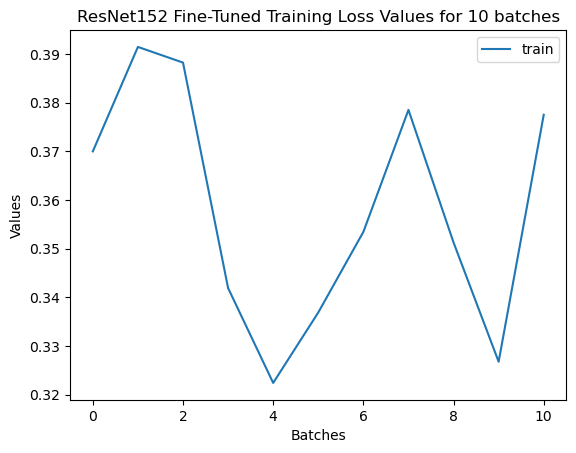

In [16]:
plt.plot(train_losses, label='train')
plt.title(f'ResNet152 Fine-Tuned Training Loss Values for {len(train_losses)-1} batches')
plt.ylabel('Values')
plt.xlabel('Batches')
plt.legend()                                                                            
plt.show()

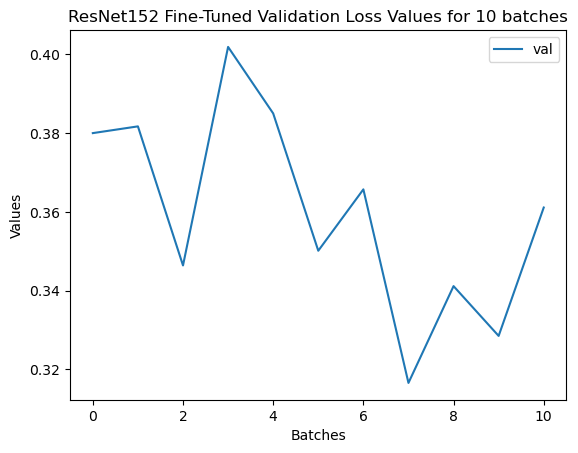

In [17]:
plt.plot(val_losses, label='val')
plt.title(f'ResNet152 Fine-Tuned Validation Loss Values for {len(val_losses)-1} batches')
plt.ylabel('Values')
plt.xlabel('Batches')
plt.legend()
plt.show()

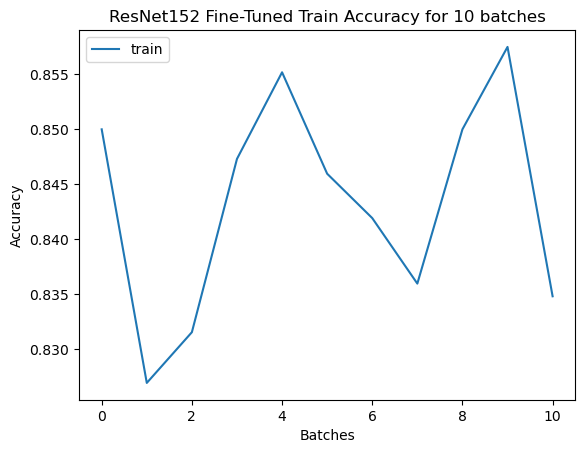

In [18]:
plt.plot(train_accuracy, label='train')
plt.title(f'ResNet152 Fine-Tuned Train Accuracy for {len(train_accuracy)-1} batches')
plt.ylabel('Accuracy')
plt.xlabel('Batches')
plt.legend()
plt.show()

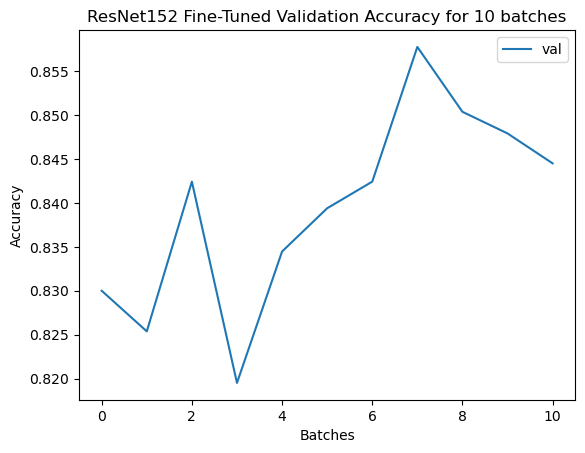

In [19]:
plt.plot(val_accuracy, label='val')
plt.title(f'ResNet152 Fine-Tuned Validation Accuracy for {len(val_accuracy)-1} batches')
plt.ylabel('Accuracy')
plt.xlabel('Batches')
plt.legend()
plt.show()

In [20]:
max(val_accuracy[1:])

0.8577651625329797

In [21]:
min(val_losses[1:])

0.31655777821486647

In [9]:
from PIL.Image import open as open_img
from pathlib import Path

has_flagellum = []
file_path = 'data/test'
to_tensor = transforms.ToTensor()
resize = transforms.Resize((224,224))


@torch.no_grad
def evaluate():
    loop = tqdm(total=439, position=0)
    model.eval()
    for file in Path(file_path).iterdir():
        loop.update(1)

        img = open_img(f'{file_path}/{file.name}')
        x_grey = to_tensor(resize(img))
        x = torch.zeros((3,224,224))
        x[0,:,:] = x_grey[:,:,:]
        x[1,:,:] = x_grey[:,:,:]
        x[2,:,:] = x_grey[:,:,:]

        y_hat = model(x.unsqueeze(0).to(device))

        if y_hat.argmax(1)[0] == 1:
            has_flagellum.append(f'{file_path}/{file.name}')
        

evaluate()

100%|██████████| 439/439 [00:48<00:00,  9.04it/s]


In [10]:
print(len(has_flagellum))

202
